# Direct Ranking Model

In [1]:
import sys

!{sys.executable} -m pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_megafon
from sklift.models import TwoModels
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


%matplotlib inline
seed=31

## Load Data

In [3]:
dataset = fetch_megafon()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

  0%|          | 0.00/276M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (600000, 50)
Dataset target shape: (600000,)
Dataset treatment shape: (600000,)


In [4]:
combined_df = pd.concat([dataset.data, dataset.treatment, dataset.target], axis=1)
combined_df["treatment_group"] = combined_df["treatment_group"].map({
    'control': 0, 
    'treatment': 1
})
print(combined_df.shape)

combined_df.head()

(600000, 52)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1,0


## Simulate Spending

In [5]:
trmnt_group_converted = combined_df[(combined_df["treatment_group"] == 1) & (combined_df["conversion"] == 1)]
ctrl_group_converted = combined_df[(combined_df["treatment_group"] == 0) & (combined_df["conversion"] == 1)]
non_converted = combined_df[combined_df["conversion"] == 0]

print(trmnt_group_converted.shape)
print(ctrl_group_converted.shape)
print(non_converted.shape)

(68760, 52)
(53754, 52)
(477486, 52)


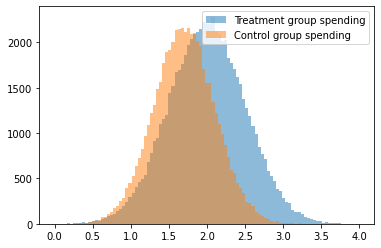

In [6]:
# Create a noisy spending data for the treatment group
np.random.seed(42)
trmnt_group_spending = np.random.normal(2, 0.5, len(trmnt_group_converted))
ctrl_group_spending = np.random.normal(1.7, 0.4, len(ctrl_group_converted))


bins = np.linspace(0, 4, 100)
plt.hist(trmnt_group_spending, bins, alpha=0.5, label='Treatment group spending')
plt.hist(ctrl_group_spending, bins, alpha=0.5, label='Control group spending')
plt.legend(loc='upper right')
plt.show()

In [7]:
trmnt_group_converted["spending"] = trmnt_group_spending
ctrl_group_converted["spending"] = ctrl_group_spending
non_converted["spending"] = 0

combined_df_with_spending = pd.concat([trmnt_group_converted, ctrl_group_converted, non_converted])
print(combined_df_with_spending.shape)

combined_df_with_spending.head()

(600000, 53)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion,spending
20,-66.700613,-0.579581,53.838094,25.125590,6.743822,-8.751333,88.423510,-18.628297,104.642760,-130.664072,...,-1.367072,4.602121,-0.701179,-153.587504,-18.442791,-50.597738,-8.983202,1,1,2.248357
21,-11.512303,1.287760,-29.249913,-57.810113,11.730489,-326.999106,-48.039201,-305.065456,42.028536,298.844066,...,0.767403,16.663241,0.252728,-304.312779,75.268100,193.895515,1.386769,1,1,1.930868
41,-22.128035,-0.687876,-50.717555,-58.895313,50.794898,-26.065448,50.189709,-18.568091,-3.744784,-226.544974,...,-0.803531,-119.757905,-0.236279,-708.708863,181.176921,-89.133027,49.941668,1,1,2.323844
58,-75.898294,0.309707,-12.084663,35.887178,67.907062,-38.705282,27.283067,99.135893,31.750946,158.596495,...,-0.119334,85.093724,0.488970,31.481788,88.314766,-46.519348,30.214437,1,1,2.761515
60,29.192624,-1.376180,44.365112,68.403800,-41.818524,22.317416,0.086787,-100.219033,26.132823,416.413998,...,1.026432,-54.872579,-0.283652,1081.831614,205.656049,153.551092,13.986240,1,1,1.882923


In [8]:
feature_cols = [col for col in combined_df_with_spending.columns if col.startswith("X_")]
print(f"Number of features: {len(feature_cols)}")

Number of features: 50


In [9]:
# Shuffle the data
full_data = combined_df_with_spending.sample(frac=1, random_state=42)
print(full_data.shape)

full_data.head()

(600000, 53)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion,spending
37241,30.391239,0.135635,-38.570025,49.263597,120.389644,-102.594615,-1.361772,83.559162,82.942751,258.863139,...,-1.230521,14.412261,-0.561299,708.670138,-197.715413,-53.933253,-14.364639,1,1,1.705054
529683,77.689423,1.215384,32.574152,-49.665542,15.220808,116.231168,37.602069,14.854413,-50.319782,90.566993,...,-1.167994,-140.364986,1.286426,-91.062756,-76.050655,-214.198314,-33.071350,1,1,2.042406
339581,19.176133,-1.353427,-27.029853,77.017433,34.941023,99.308737,69.612477,-74.093750,-34.120708,235.142052,...,-0.517577,-25.496290,0.598395,-148.576784,62.919702,-124.503096,19.781948,0,0,0.000000
363488,-73.359977,0.910815,17.594132,-35.772728,20.484921,-78.936500,78.588632,64.824181,23.802910,94.292610,...,0.522036,76.699273,-2.716671,-366.043860,74.837081,-15.626338,21.535789,1,1,1.135101
429306,-93.580934,-0.033293,-32.532419,-4.021167,-58.597782,22.771683,79.381321,-93.265539,17.567098,-145.748250,...,1.241179,36.094642,0.400099,-418.849066,-8.175022,-56.106051,6.096248,0,0,0.000000


In [10]:
stratify_cols = full_data[["treatment_group", "conversion"]]

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val, spending_train, spending_val = train_test_split(
    full_data[feature_cols],
    full_data["treatment_group"],
    full_data["conversion"],
    full_data["spending"],
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (420000, 50)
Validation shape: (180000, 50)


## Direct Ranking Model

### Scoring layer

In [11]:
import tensorflow as tf
from tensorflow.keras import layers

In [12]:
s = tf.constant([1, 2, 3, 4, 5])
# T = tf.constant([0, 1, 0, 0, 1])
T = tf.constant([1, 1, 0, 0, 1])
sum = tf.math.unsorted_segment_sum(s, T, num_segments=2)
print(f"Sum: {sum}")
print(tf.map_fn(lambda x: sum.numpy()[x], T))

tf.math.divide(s, tf.map_fn(lambda x: sum.numpy()[x], T))

Sum: [7 8]
tf.Tensor([8 8 7 7 8], shape=(5,), dtype=int32)


<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.125     , 0.25      , 0.42857143, 0.57142857, 0.625     ])>

In [13]:
class Scoring(layers.Layer):
    def __init__(self):
        super(Scoring, self).__init__()

    def call(self, s, T):
        sum_scores = tf.math.unsorted_segment_sum(
            tf.math.exp(s), T, num_segments=2
        )
        # print(f"sum_scores: {sum_scores}")
        return tf.math.divide(
            tf.math.exp(s),
            tf.map_fn(
                fn=lambda x: sum_scores.numpy()[x],
                elems=T,
                fn_output_signature=tf.float32
            )
        )

In [14]:
# s = tf.constant([1, 2, 3, 4, 5])
# T = tf.constant([1, 1, 0, 0, 1])
s = tf.constant([1, 2, 3, 4, 5], dtype=tf.float32)
T = tf.constant([1, 1, 0, 0, 1], dtype=tf.int32)
scoring_layer = Scoring()
scoring_layer(s, T)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.01714782, 0.04661262, 0.26894143, 0.7310586 , 0.9362395 ],
      dtype=float32)>

### Creating dataset

In [15]:
train_data = pd.concat([X_train, trmnt_train, y_train, spending_train], axis=1)
val_data = pd.concat([X_val, trmnt_val, y_val, spending_val], axis=1)

train_data.shape, val_data.shape

((420000, 53), (180000, 53))

In [16]:
def make_dataset(dataframe, feature_cols, batch_size, weights):
    df = dataframe.copy()
    num_rows = len(df)
    features = df[feature_cols]
    treatment = df.pop("treatment_group")
    spend = df.pop("spending")
    ds = tf.data.Dataset.from_tensor_slices((features, treatment, spend))
    ds = ds.shuffle(buffer_size=num_rows)
    negative_ds = ds.filter(lambda features, treatment, spend: spend <= 0)
    positive_ds = ds.filter(lambda features, treatment, spend: spend > 0)
    balanced_ds = tf.data.Dataset.sample_from_datasets(
        [negative_ds, positive_ds], weights
    ).batch(batch_size)
    return balanced_ds

In [17]:
train_ds = make_dataset(
    train_data, feature_cols, batch_size=64, weights=[0.8, 0.2]
)
for _, treatment, spend in train_ds.take(3):
    print(treatment)
    print(spend)
    print("\n")

tf.Tensor(
[1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0], shape=(64,), dtype=int64)
tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         1.43613336 2.92134711 0.         0.
 0.         0.         0.         2.53476985 0.         1.83842566
 2.17192211 0.         0.         0.         0.         0.
 0.         0.         0.         1.972505   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         2.70049138 0.         0.         0.
 1.85449634 0.         0.         1.12159508 2.33756853 0.
 0.         0.         0.         0.         0.         0.
 0.         1.52576647 1.46117996 0.        ], shape=(64,), dtype=float64)


tf.Tensor(
[1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0
 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0], sh

### Direct ranking model

In [18]:
RATE = 0.1

class DirectRankingModel(tf.keras.Model):
    def __init__(self, n_units):
        super(DirectRankingModel, self).__init__()
        self.dense1 = layers.Dense(n_units, activation='tanh')
        self.dense2 = layers.Dense(1)
        self.scoring = Scoring()

    def compute_loss(self, y_cost, y_gain, scores, treatment):
        """Calculate cost per incremental gain"""
        t = tf.map_fn(fn=lambda x: 1 if x==1 else -1, elems=treatment)
        # t = tf.cast(t, tf.float32)
        t = tf.math.scalar_mul(RATE, t)
        # print(f"compute_loss => t: {t}")
        # print(f"compute_loss => scores: {tf.transpose(scores)}")
        # print(f"compute_loss => y_cost: {tf.transpose(y_cost)}")
        # print(f"compute_loss => y_gain: {tf.transpose(y_gain)}")
        scores = tf.squeeze(scores)
        y_cost = tf.cast(y_cost, tf.float32)
        agg_cost = tf.tensordot(y_cost, tf.math.multiply(scores, t), axes=1)
        agg_gain = tf.tensordot(y_gain, tf.math.multiply(scores, t), axes=1)

        # Add a constant term to the total gain to avoid division by 0
        agg_gain = tf.add(agg_gain, 1)
        # print(f"compute_loss => agg_cost: {agg_cost} ------ agg_gain: {agg_gain}")
        return agg_cost / agg_gain

    def call(self, inputs):
        x, T, spend = inputs
        x = self.dense1(x)
        x = self.dense2(x)
        scores = self.scoring(x, T)
        cpig_loss = self.compute_loss(T, spend, scores, T)
        return scores, cpig_loss

In [19]:
tf.config.run_functions_eagerly(True)


drm = DirectRankingModel(n_units=128)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3
    # learning_rate=1e-2, clipnorm=1.0
    # learning_rate=1e-2, clipvalue=0.5
)

@tf.function
def train_step(x, t, g):
    with tf.GradientTape() as tape:
        scores, loss = drm((x, t, g), training=True)
    grads = tape.gradient(loss, drm.trainable_weights)
    optimizer.apply_gradients(zip(grads, drm.trainable_weights))
    return loss


# @tf.function
# def test_step(x, y):
#     val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [20]:
N = 2
for epoch in range(N):
    print("Start of epoch %d" % (epoch,))
    loss_tracker = []

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, t_batch_train, g_batch_train) in enumerate(train_ds):
        loss = train_step(x_batch_train, t_batch_train, g_batch_train)
        loss_tracker.append(loss)
        if step % 100 == 0:
            avg_loss = np.mean(loss_tracker[-100:])
            print("step %d: mean loss = %.4f" % (step, avg_loss))
            # print(grads)
    
    print("\n")

Start of epoch 0
step 0: mean loss = 0.0743
step 100: mean loss = 0.0896
step 200: mean loss = 0.0901
step 300: mean loss = 0.0875
step 400: mean loss = 0.0901
step 500: mean loss = 0.0917
step 600: mean loss = 0.0946
step 700: mean loss = 0.0886
step 800: mean loss = 0.0908
step 900: mean loss = 0.0897
step 1000: mean loss = 0.0911
step 1100: mean loss = 0.0899
step 1200: mean loss = 0.0923
step 1300: mean loss = 0.0908
step 1400: mean loss = 0.0882
step 1500: mean loss = 0.0869
step 1600: mean loss = 0.0925
step 1700: mean loss = 0.0934
step 1800: mean loss = 0.0877


KeyboardInterrupt: ignored

## References

* Making new Layers and Models via subclassing
https://www.tensorflow.org/guide/keras/custom_layers_and_models

* https://stackoverflow.com/questions/37107223/how-to-add-regularizations-in-tensorflow